# The data is collected from - [here](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names)

We first import all the necessary libarries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
from PIL import Image


from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import TensorBoard
from keras import optimizers
from keras import regularizers

%matplotlib inline

Using TensorFlow backend.


We define some functions that we are going to use to prepare our data. Make a note there is absolutely no 
feature engineering going on here apart from numeratizing some text values.

In [6]:
def strip_it(s):
    if isinstance(s, str):
        return s.strip()
    else:
        return ''

    
def prepare_data(file_name, income_str="<=50K"):
    """To prepare our training and test sets.
    """
    names = ["age", "workclass", "finalweight", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
    df = pd.read_csv(file_name, index_col=False, header=None, names=names)
        
    # bcause we need to assign 1 to > 50k
    df['income'] = np.where(df.income.str.strip() == income_str, "0", "1")
    
    # Converting training data
    df['workclass'].replace(' ?', np.nan, inplace=True)
    df['native-country'].replace(' ?', np.nan, inplace=True)
    df['education'].replace(' ?', np.nan, inplace=True)
    df['occupation'].replace(' ?', '', inplace=True)
    df['relationship'].replace(' ?', '', inplace=True)
    df['native-country'].replace(' ?', '', inplace=True)

    workclass_rep = {'State-gov': 1, 'Self-emp-not-inc': 2, 'Private': 3, 'Federal-gov': 4,
           'Local-gov': 5, 'Self-emp-inc': 6, 'Without-pay': 7, 'Never-worked': 8}

    df['workclass_num'] = pd.Series(df['workclass'].apply(lambda x: workclass_rep[x.strip()] if x is not np.nan else np.nan))
    # education_rep = {'Bachelors': 1, 'HS-grad': 2, '11th': 3, 'Masters': 4, '9th': 5,
    #         'Some-college': 6, 'Assoc-acdm': 7, 'Assoc-voc': 8, '7th-8th': 9,
    #         'Doctorate': 10, 'Prof-school': 11, '5th-6th': 12, '10th': 13, '1st-4th': 14,
    #         'Preschool': 15, '12th': 16}
    # df['education_num'] = df['education'].apply(lambda x: education_rep[x.strip()] if x is not np.nan else np.nan)

    marital_rep = {'Never-married': 1, 'Married-civ-spouse': 2, 'Divorced': 3,
           'Married-spouse-absent': 5, 'Separated': 6, 'Married-AF-spouse': 7,
            'Widowed': 8}
    df['marital_status_num'] = df['marital-status'].apply(lambda x: marital_rep[x.strip()] if x is not np.nan else np.nan)

    df.dropna(subset=['workclass', 'native-country', 'education'])

    oc = map(strip_it, df['occupation'].unique())
    occ = {o: idx+1 for idx, o in enumerate(oc) if o}
    df['occupation_num'] = pd.Series(df['occupation'].apply(lambda x: occ[x.strip()] if isinstance(x, str) and x.strip() in occ else np.nan))

    oc = map(strip_it, df['relationship'].unique())
    occ = {o: idx+1 for idx, o in enumerate(oc) if o}
    df['relationship_num'] = pd.Series(df['relationship'].apply(lambda x: occ[x.strip()] if isinstance(x, str) and x.strip() in occ else np.nan))

    oc = map(strip_it, df['native-country'].unique())
    occ = {o: idx+1 for idx, o in enumerate(oc) if o}
    df['native-country_num'] = pd.Series(df['native-country'].apply(lambda x: occ[x.strip()] if isinstance(x, str) and x.strip() in occ else np.nan))

    df1 = df[['age', 'education-num', 'finalweight', 'hours-per-week', 'workclass_num', 'marital_status_num', 'occupation_num', 'native-country_num', 'capital-gain', 'capital-loss', 'income']]
    df2 = df1.dropna()
    
    df2.apply(pd.to_numeric, errors='ignore')
    Xtemp = df2[['age', 'education-num', 'finalweight', 'hours-per-week', 'workclass_num', 'marital_status_num', 'occupation_num', 'native-country_num', 'capital-gain', 'capital-loss']]
    Xtemp['avg_finalweight'] = Xtemp.apply(lambda row: row['finalweight'] / Xtemp.shape[0], axis=1)
    Xtemp.drop('finalweight', axis=1, inplace=True)
    y = df2['income']

    return Xtemp, y


def normalize(xval):
    """To normalize the data
    """
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    X = min_max_scaler.fit_transform(xval)
    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)
    X = X.astype('float32')
    return X

We load the data now.

In [7]:
xtemp1, y1 = prepare_data('adult.data')
xtemp2, y2 = prepare_data('adult.test', income_str="<=50K.")

Let's check the dimension of the input matrices.

In [8]:
print(xtemp1.shape)
print(xtemp2.shape)

(30162, 10)
(15060, 10)


*The above numbers match the description of the dataset* 

It *also* tells us that we have a total of 30162 number of training examples each with 10 features and a total of 15060 number of test examples. 

it is time to normalize things.

In [9]:
X = normalize(xtemp1)
Y = y1.values.reshape(y1.shape[0], 1)

We assign the values to training sets. Just a convinient way to name variables for later use.

In [10]:
x_train = X
y_train = Y

As we will be using the test set to predict, we will normalize the data as well.

In [12]:
X = normalize(xtemp2)
Y = y2.values.reshape(y2.shape[0], 1)

And then, similarly, assign them to some variables with a nice name.

In [13]:
x_test = X
y_test = Y

## Time to build the Neural Net now!

In [15]:
# We need this to make a train-dev set split
from sklearn.model_selection import train_test_split
# Calculate the input dimension.
inpdim = x_train.shape[1]

# Create an optimizer
optim = optimizers.adam(lr=0.0001)

# This is not really used for now!
cvscores = []

# Build the network. 16->16->16->1 ... we are doing Deep Learning!
model = Sequential()
# The kernel_regularizer is the same as weight regularizer.
model.add(Dense(16, input_dim=inpdim, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dropout(0.7))  # Not for now. 
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dropout(0.7))  #  Not for now
model.add(Dense(1, activation='sigmoid'))

# Compile our model to be reda
model.compile(loss='binary_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])
# Train the model, iterating on the data in batches of 32 samples
x_train_splt, x_test_splt, y_train_splt, y_test_splt = train_test_split(x_train, y_train, test_size=0.1, random_state=0)

his = model.fit(x_train_splt, y_train_splt, epochs=100, batch_size=32)
scores = model.evaluate(x_test_splt, y_test_splt, verbose=0)
cvscores.append((scores[0], scores[1]))

Epoch 1/100
27145/27145 [==============================] - 1s - loss: 0.9136 - acc: 0.7618     
Epoch 2/100
27145/27145 [==============================] - 1s - loss: 0.7403 - acc: 0.7848     
Epoch 3/100
27145/27145 [==============================] - 0s - loss: 0.6442 - acc: 0.7966     
Epoch 4/100
27145/27145 [==============================] - 1s - loss: 0.5811 - acc: 0.8046     
Epoch 5/100
27145/27145 [==============================] - 1s - loss: 0.5403 - acc: 0.8098     
Epoch 6/100
27145/27145 [==============================] - 1s - loss: 0.5132 - acc: 0.8109     
Epoch 7/100
27145/27145 [==============================] - 1s - loss: 0.4945 - acc: 0.8137     
Epoch 8/100
27145/27145 [==============================] - 1s - loss: 0.4811 - acc: 0.8154     
Epoch 9/100
27145/27145 [==============================] - 1s - loss: 0.4711 - acc: 0.8178     
Epoch 10/100
27145/27145 [==============================] - 0s - loss: 0.4631 - acc: 0.8190     
Epoch 11/100
27145/27145 [=============

27145/27145 [==============================] - 0s - loss: 0.3788 - acc: 0.8445     
Epoch 86/100
27145/27145 [==============================] - 0s - loss: 0.3786 - acc: 0.8441     
Epoch 87/100
27145/27145 [==============================] - 0s - loss: 0.3784 - acc: 0.8438     
Epoch 88/100
27145/27145 [==============================] - 1s - loss: 0.3783 - acc: 0.8442     
Epoch 89/100
27145/27145 [==============================] - 1s - loss: 0.3780 - acc: 0.8444     
Epoch 90/100
27145/27145 [==============================] - 1s - loss: 0.3777 - acc: 0.8445     
Epoch 91/100
27145/27145 [==============================] - 1s - loss: 0.3776 - acc: 0.8439     
Epoch 92/100
27145/27145 [==============================] - 1s - loss: 0.3773 - acc: 0.8441     
Epoch 93/100
27145/27145 [==============================] - 1s - loss: 0.3773 - acc: 0.8443     
Epoch 94/100
27145/27145 [==============================] - 1s - loss: 0.3770 - acc: 0.8444     
Epoch 95/100
27145/27145 [=================

Let's plot the learning(accuracy) and error - 

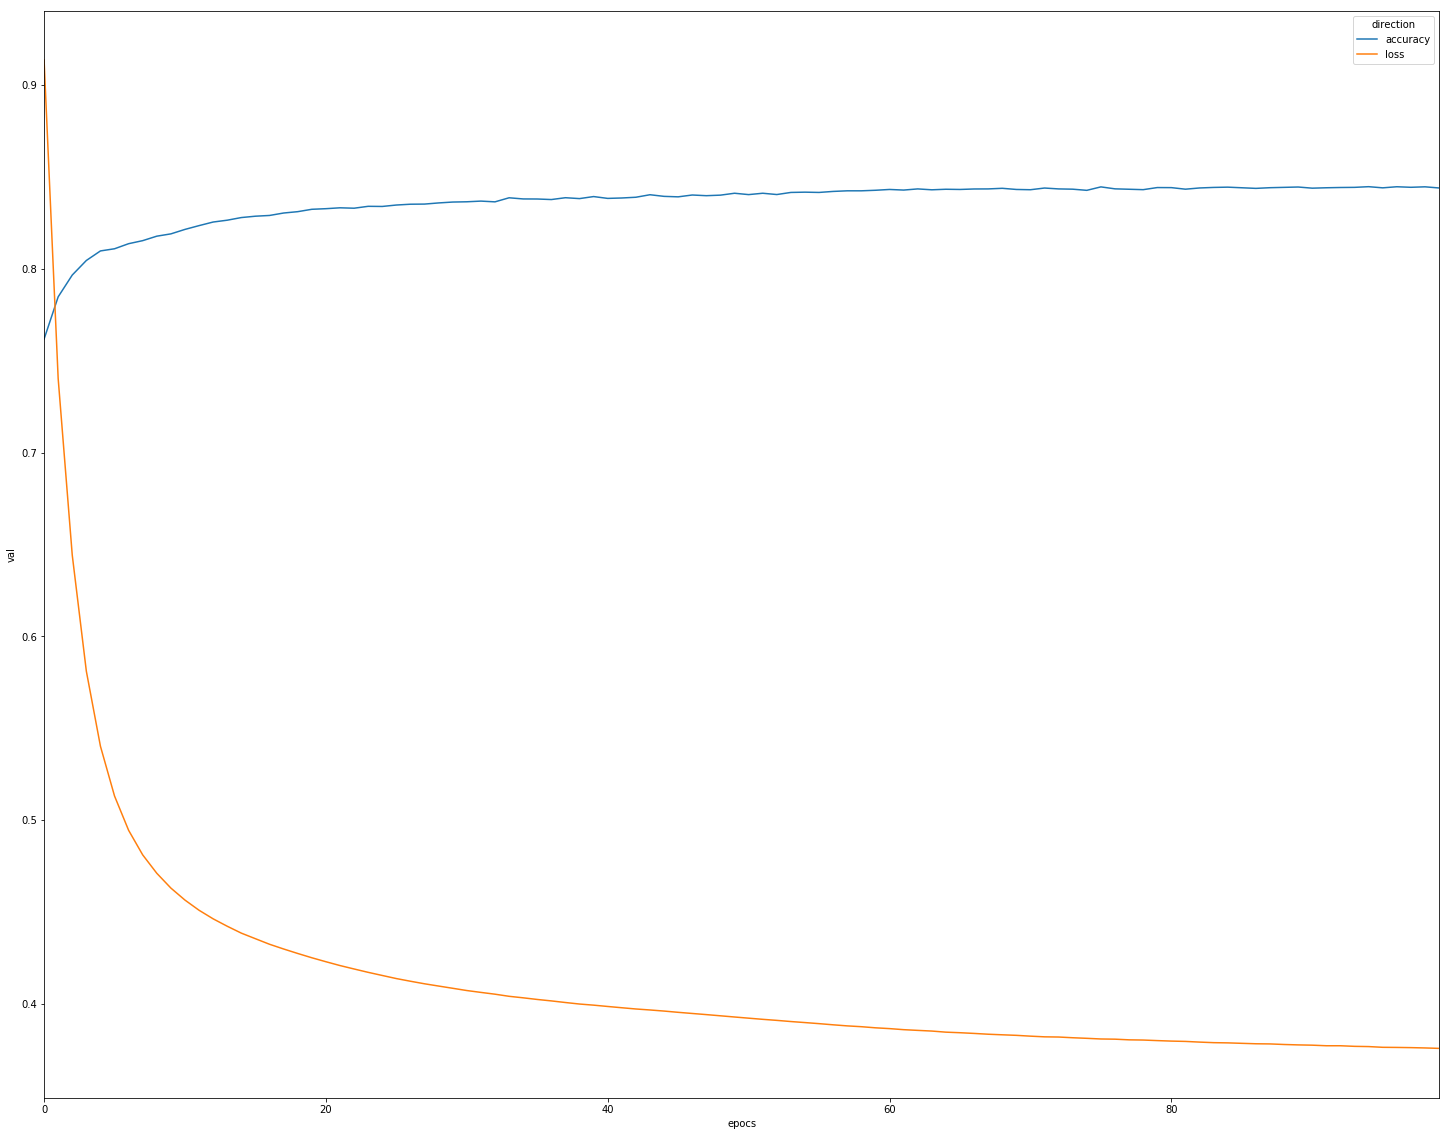

In [17]:
import warnings
warnings.filterwarnings('ignore')
epochs = [idx for idx, _ in enumerate(his.history['acc'])]
pf1 = pd.DataFrame({'epocs': epochs, 'val': his.history['acc'], 'direction':'accuracy'})
pf2 = pd.DataFrame({'epocs': epochs, 'val': his.history['loss'], 'direction':'loss'})
plot_frame = pd.concat([pf1,pf2],axis=0)
plot_frame['unit'] = 'subject'

fig = plt.figure(figsize=(25,20))
sns.tsplot(data=plot_frame, time='epocs', condition='direction',
unit='unit', value='val')

Looks nice! It seems that our model learned well. Let us try some predictions.

In [18]:
p = model.predict(x_test)
p_actual = np.where(p <= 0.5, 0, 1)
right_preds = []
for i in range(len(y_test)):
    yt = y_test[i]
    pt = p_actual[i]
    if yt.astype(int)==pt.astype(int):
        right_preds.append(1)

print("We predicted {} rightly among {} total".format(len(right_preds), y_test.shape[0]))
print("=============================================")
print("Which is - {}%".format((len(right_preds) / y_test.shape[0])*100))

We predicted 12677 rightly among 15060 total
Which is - 84.17662682602922%


This means, in the test set we have a (100-84.18) = 15.82% error. Not Bad! 